In [1]:
# importing all the required libraries
import pandas as pd
from google.colab import files
import io
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import keras
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Softmax
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import sklearn.decomposition
import keras.callbacks
import pickle
import re
import nltk
from nltk.stem import PorterStemmer

In [2]:
uploaded = files.upload()

Saving Functional_Consequences_v1.xlsx to Functional_Consequences_v1.xlsx


Defining custom early stopper classes for early stopping of model.fit keras method

In [3]:
class CustomStopper(keras.callbacks.EarlyStopping):
    def __init__(self, monitor='val_loss',
             min_delta=0, patience=10, verbose=0, mode='auto', start_epoch = 30): # add argument for starting epoch
        super(CustomStopper, self).__init__()
        self.start_epoch = start_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch > self.start_epoch:
            super().on_epoch_end(epoch, logs)

Defining variables to be passes in the various methods

In [4]:
filename = 'Data_v1.xlsx' #file name of the uploaded dataset file  
modelName = 'Model1' #name of the model, this will be used to save model evaluation and history
numEpochs  = 150 # maximum number of epochs if early stopping doesnt work
batchsize = 50 # batchsize which will be used in each step by optimizer defined in the model
optimizer = 'adadelta' #optimizer to be used in model.fit keras method


Method to read uploaded file. Returns back the text input samples and target labels for each. Transforms X to a vector which holds the number of occurences of each word for every sample

In [49]:
def mypreprocessor(text):
  porter_stemmer = PorterStemmer()
  words=re.split("\\s+",text)
  stemmed_words=[porter_stemmer.stem(word=word) for word in words]
  return ' '.join(stemmed_words)
  
def Preprocessing():
  
  X = pd.read_excel(list(uploaded.items())[0][0],usecols="H") #pass usecols as the column containing all the training samples
  y = pd.read_excel(list(uploaded.items())[0][0],usecols="F") #pass usecols as the column containing all the target labels
  X = [str(i) for i in X.extracted_text.to_list()] #the property used with X. should match column name in excel
  
  # for i in range(len(X)):
  #   X[i] = re.sub(r'(\s\d+\s)|{\d+}|\(\d+\)','',X[i])
  #   X[i] = re.sub(r'gain-of-function|gain of function|toxic gain of function|activating mutation|constitutively active|hypermorph|ectopic expression|neomorph|gain of interaction|function protein|fusion transcript','GOF',X[i])
  #   X[i] = re.sub(r'haploinsufficiency|haploinsufficient|hypomorph|amorph|null mutation|hemizygous','HI',X[i])
  #   X[i] = re.sub(r'dominant-negative|dominant negative|antimorph','DN',X[i])
  #   X[i] = re.sub(r'loss of function|loss-of-function','LOF',X[i])

      # X = preprocess_data(X)
  y = y.mutation_consequence.to_list()
  # vocabulary = ['gain-of-function','gain of function',
  #               'toxic gain of function','activating mutation',
  #               'constitutively active','hypermorph','ectopic expression',
  #               'neomorph','gain of interaction','function protein','fusion transcript',
  #               'haploinsufficiency','haploinsufficient','hypomorph','amorph',
  #               'null mutation','hemizygous','dominant-negative','dominant negative','antimorph',
  #               'loss of function','loss-of-function']
  X=TfidfVectorizer(X,preprocessor=mypreprocessor,max_df=200 ,ngram_range=(1, 2)).fit(X).transform(X)
  # X=CountVectorizer(X,preprocessor=mypreprocessor,max_df=200 ,ngram_range=(1, 2)).fit(X).transform(X)
  return X, y

Method to split the dataset into training and testing. Changes y to one-hot encoded vector, e.g if target class is 3, then returns [0,0,0,1,0] for 5 target classes

In [18]:
def TrainTestSplit(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=100, stratify = y) #split the dataset, test_Size variable defines the size of the test dataset, stratify column makes sure even distribution of target labels

  X_train = X_train.toarray() #changing to numpy array to work with keras sequential model
  X_test = X_test.toarray() #changing to numpy array to work with keras sequential model
  le  = LabelEncoder() 
  y_train = to_categorical(le.fit(y_train).transform(y_train))
  y_test = to_categorical(le.fit(y_test).transform(y_test))
  return X_train, X_test, y_train, y_test, le.classes_ # returns training and test datasets, as well as class names

Defining the model to be used for training the datasets.


In [28]:
def ModelBuild(X, y):
  inputs = keras.layers.Input(shape=(len(X_train[0]),))
  dense1 = keras.layers.Dense(200, activation="relu")(inputs) #fully connected with input vectors
  
  
  # dropout  = keras.layers.Dropout(0.2)(dense1) #regularization layer if required
  dense2 = keras.layers.Dense(50, activation="relu")(dense1) #fully connected with Layer 1
  # dropout2 = keras.layers.Dropout(0.1)(dense2) #regularization layer if required
  # dense3  = keras.layers.Dense(50, activation="relu")(dense2)
  
  outputs = keras.layers.Dense(len(y_train[0]), activation="sigmoid")(dense2) #output layer
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

Method to show summary of the model as well as the shape in diagram form

In [21]:
def PlotModel(model, filename):
  model.summary()
  keras.utils.plot_model(model, filename, show_shapes=True)

Method to compile the defined model as well as run the training. Returns a history variable which can be used to plot training and validation loss as well as accuracy at every epoch

In [22]:
def PlotTraining(model, X_test, y_test):
  model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=[keras.metrics.CategoricalAccuracy(),'accuracy'])
  # EarlyStoppage = CustomStopper()
  es = keras.callbacks.EarlyStopping(monitor='val_accuracy', baseline=0.7, patience=30)
  history = model.fit(X_train, y_train,validation_split=0.2,epochs=numEpochs, batch_size=batchsize) #,callbacks = [es] ) - use this for early stopping
  model.evaluate(X_test, y_test)
  return history
  

Plots the validation and training accuracy at every epoch using a history object obtained by model.fit in the previous step

In [23]:
def plot(history):
  # list all data in history
    print(history.keys())
    # summarize history for accuracy
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Calling the methods to run all the required steps in the pipeline

In [26]:
X, y = Preprocessing()
X_train, X_test, y_train, y_test, ClassNames = TrainTestSplit(X, y)
# svd = sklearn.decomposition.TruncatedSVD(n_components=60, n_iter=5, random_state=42)
# X_train = svd.fit(X_train).transform(X_train)
# svd = sklearn.decomposition.TruncatedSVD(n_components=60, n_iter=5, random_state=42)
# X_test = svd.fit(X_test).transform(X_test)
model = ModelBuild(X_train, y_train)
PlotModel(model, modelName +".png")
history = PlotTraining(model, X_test, y_test)
print(confusion_matrix(y_test.argmax(axis=-1),model.predict(X_test).argmax(axis=-1)))
print(classification_report(y_test.argmax(axis=-1), model.predict(X_test).argmax(axis=-1),target_names=ClassNames))


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112443)]          0         
_________________________________________________________________
dense (Dense)                (None, 200)               22488800  
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 22,509,405
Trainable params: 22,509,405
Non-trainable params: 0
_________________________________________________

dict_keys(['loss', 'categorical_accuracy', 'accuracy', 'val_loss', 'val_categorical_accuracy', 'val_accuracy'])


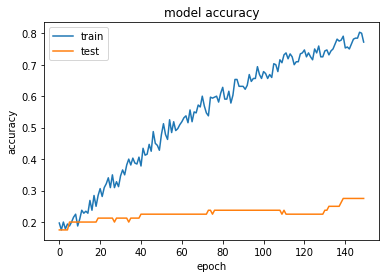

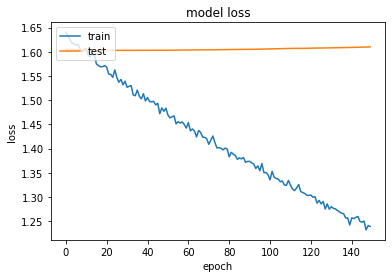

In [27]:
with open('/content/%s' %modelName, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
history = pickle.load(open('/content/%s' % modelName, "rb"))
model.save(modelName +'.h5')
plot(history)
with open('/content/%s_train' %modelName, 'wb') as file_pi:
        pickle.dump(X_train, file_pi)
with open('/content/%s_test' %modelName, 'wb') as file_pi:
        pickle.dump(X_test, file_pi)
with open('/content/%s_Labeltest' %modelName, 'wb') as file_pi:
        pickle.dump(y_test, file_pi)
with open('/content/%s_LabelTrain' %modelName, 'wb') as file_pi:
        pickle.dump(y_train, file_pi)
with open('/content/%s_ConfusionMatrix' %modelName, 'wb') as file_pi:
        pickle.dump(confusion_matrix(y_test.argmax(axis=-1), model.predict(X_test).argmax(axis=-1)), file_pi)
with open('/content/%s_ClassificationReport' %modelName, 'wb') as file_pi:
        pickle.dump(classification_report(y_test.argmax(axis=-1), model.predict(X_test).argmax(axis=-1), target_names=ClassNames), file_pi)

Running above solution with reduced text and preprocessing

In [29]:
uploaded = files.upload()

Saving Data_v2.xlsx to Data_v2.xlsx


In [30]:
modelName = 'Model2' #name of the model, this will be used to save model evaluation and history
numEpochs  = 150 # maximum number of epochs if early stopping doesnt work
batchsize = 50 # batchsize which will be used in each step by optimizer defined in the model
optimizer = 'adam' #optimizer to be used in model.fit keras method


Calling the above pipeline again with new parameters

In [36]:
X, y = Preprocessing()
X_train, X_test, y_train, y_test, ClassNames = TrainTestSplit(X, y)
model = ModelBuild(X_train, y_train)
PlotModel(model, modelName +".png")
history = PlotTraining(model, X_test, y_test)
print(confusion_matrix(y_test.argmax(axis=-1),model.predict(X_test).argmax(axis=-1)))
print(classification_report(y_test.argmax(axis=-1), model.predict(X_test).argmax(axis=-1),target_names=ClassNames))


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 55389)]           0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               27695000  
_________________________________________________________________
dense_4 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 505       
Total params: 27,745,605
Trainable params: 27,745,605
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
7/7 [==============================] - 2s 268ms/step - loss: 1.5695 - categorical_accuracy: 0.2738 - accuracy: 0.2738 - val_loss: 1.3374 - val_categorical_accuracy: 0.6364 - val_accuracy: 0.6364
Epoch 2/150
7/7 [=====================

dict_keys(['loss', 'categorical_accuracy', 'accuracy', 'val_loss', 'val_categorical_accuracy', 'val_accuracy'])


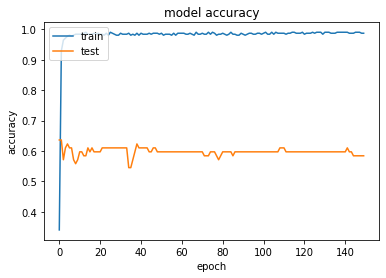

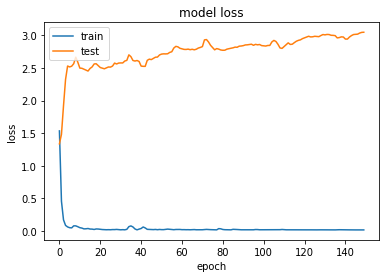

In [37]:
with open('/content/%s' %modelName, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
history = pickle.load(open('/content/%s' % modelName, "rb"))
model.save(modelName +'.h5')
plot(history)
with open('/content/%s_train' %modelName, 'wb') as file_pi:
        pickle.dump(X_train, file_pi)
with open('/content/%s_test' %modelName, 'wb') as file_pi:
        pickle.dump(X_test, file_pi)
with open('/content/%s_Labeltest' %modelName, 'wb') as file_pi:
        pickle.dump(y_test, file_pi)
with open('/content/%s_LabelTrain' %modelName, 'wb') as file_pi:
        pickle.dump(y_train, file_pi)
with open('/content/%s_ConfusionMatrix' %modelName, 'wb') as file_pi:
        pickle.dump(confusion_matrix(y_test.argmax(axis=-1), model.predict(X_test).argmax(axis=-1)), file_pi)
with open('/content/%s_ClassificationReport' %modelName, 'wb') as file_pi:
        pickle.dump(classification_report(y_test.argmax(axis=-1), model.predict(X_test).argmax(axis=-1), target_names=ClassNames), file_pi)

Running the model with TF-IDF vectorizer instead of CountVectorizer (adam optimizer)

In [38]:
uploaded = files.upload()

Saving Data_v2.xlsx to Data_v2 (1).xlsx


In [39]:
modelName = 'Model3' #name of the model, this will be used to save model evaluation and history
numEpochs  = 150 # maximum number of epochs if early stopping doesnt work
batchsize = 20 # batchsize which will be used in each step by optimizer defined in the model
optimizer = 'adam' #optimizer to be used in model.fit keras method

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer


For the next step, go to Preprocessing method and change CountVectorizer to TfIdfVectorizer

In [42]:
X, y = Preprocessing()
X_train, X_test, y_train, y_test, ClassNames = TrainTestSplit(X, y)
model = ModelBuild(X_train, y_train)
PlotModel(model, modelName +".png")
history = PlotTraining(model, X_test, y_test)
print(confusion_matrix(y_test.argmax(axis=-1),model.predict(X_test).argmax(axis=-1)))
print(classification_report(y_test.argmax(axis=-1), model.predict(X_test).argmax(axis=-1),target_names=ClassNames))


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 55389)]           0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)               27695000  
_________________________________________________________________
dense_7 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 505       
Total params: 27,745,605
Trainable params: 27,745,605
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
16/16 [==============================] - 3s 178ms/step - loss: 1.6028 - categorical_accuracy: 0.2213 - accuracy: 0.2213 - val_loss: 1.5433 - val_categorical_accuracy: 0.6494 - val_accuracy: 0.6494
Epoch 2/150
16/16 [=================

dict_keys(['loss', 'categorical_accuracy', 'accuracy', 'val_loss', 'val_categorical_accuracy', 'val_accuracy'])


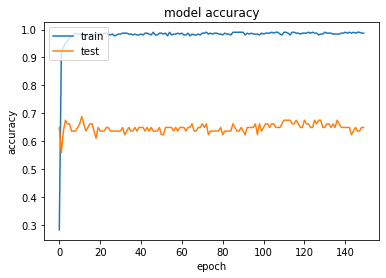

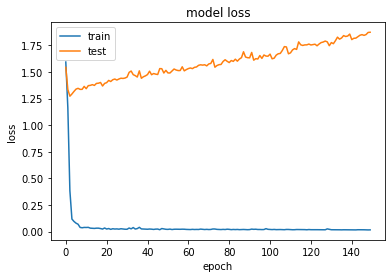

In [43]:
with open('/content/%s' %modelName, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
history = pickle.load(open('/content/%s' % modelName, "rb"))
model.save(modelName +'.h5')
plot(history)
with open('/content/%s_train' %modelName, 'wb') as file_pi:
        pickle.dump(X_train, file_pi)
with open('/content/%s_test' %modelName, 'wb') as file_pi:
        pickle.dump(X_test, file_pi)
with open('/content/%s_Labeltest' %modelName, 'wb') as file_pi:
        pickle.dump(y_test, file_pi)
with open('/content/%s_LabelTrain' %modelName, 'wb') as file_pi:
        pickle.dump(y_train, file_pi)
with open('/content/%s_ConfusionMatrix' %modelName, 'wb') as file_pi:
        pickle.dump(confusion_matrix(y_test.argmax(axis=-1), model.predict(X_test).argmax(axis=-1)), file_pi)
with open('/content/%s_ClassificationReport' %modelName, 'wb') as file_pi:
        pickle.dump(classification_report(y_test.argmax(axis=-1), model.predict(X_test).argmax(axis=-1), target_names=ClassNames), file_pi)

In [45]:
print(pickle.load(open('Model3_ClassificationReport','rb')))

              precision    recall  f1-score   support

          DN       0.41      0.45      0.43        20
         GOF       0.57      0.40      0.47        20
          HI       0.26      0.55      0.35        20
         LOF       0.36      0.20      0.26        20
        none       0.86      0.35      0.50        17

    accuracy                           0.39        97
   macro avg       0.49      0.39      0.40        97
weighted avg       0.48      0.39      0.40        97



Running model with adadelta optimizer and tfidf vectorizer

In [62]:
modelName = 'Model5' #name of the model, this will be used to save model evaluation and history
numEpochs  = 200 # maximum number of epochs if early stopping doesnt work
batchsize = 50 # batchsize which will be used in each step by optimizer defined in the model
optimizer = 'adam' #optimizer to be used in model.fit keras method

In [63]:
X, y = Preprocessing()
X_train, X_test, y_train, y_test, ClassNames = TrainTestSplit(X, y)
model = ModelBuild(X_train, y_train)
PlotModel(model, modelName +".png")
history = PlotTraining(model, X_test, y_test)
print(confusion_matrix(y_test.argmax(axis=-1),model.predict(X_test).argmax(axis=-1)))
print(classification_report(y_test.argmax(axis=-1), model.predict(X_test).argmax(axis=-1),target_names=ClassNames))


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 55389)]           0         
_________________________________________________________________
dense_12 (Dense)             (None, 500)               27695000  
_________________________________________________________________
dense_13 (Dense)             (None, 100)               50100     
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 505       
Total params: 27,745,605
Trainable params: 27,745,605
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
7/7 [==============================] - 2s 265ms/step - loss: 1.6061 - categorical_accuracy: 0.2644 - accuracy: 0.2644 - val_loss: 1.5790 - val_categorical_accuracy: 0.4805 - val_accuracy: 0.4805
Epoch 2/200
7/7 [=====================

In [59]:
X_train.shape

(385, 55389)

dict_keys(['loss', 'categorical_accuracy', 'accuracy', 'val_loss', 'val_categorical_accuracy', 'val_accuracy'])


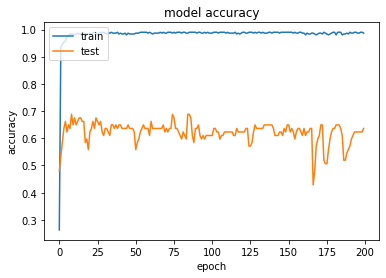

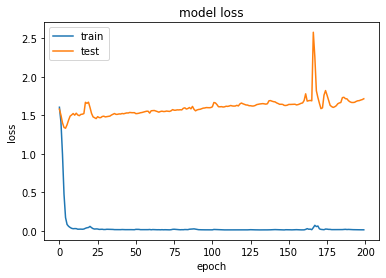

In [65]:
with open('/content/%s' %modelName, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
history = pickle.load(open('/content/%s' % modelName, "rb"))
model.save(modelName +'.h5')
plot(history)
with open('/content/%s_train' %modelName, 'wb') as file_pi:
        pickle.dump(X_train, file_pi)
with open('/content/%s_test' %modelName, 'wb') as file_pi:
        pickle.dump(X_test, file_pi)
with open('/content/%s_Labeltest' %modelName, 'wb') as file_pi:
        pickle.dump(y_test, file_pi)
with open('/content/%s_LabelTrain' %modelName, 'wb') as file_pi:
        pickle.dump(y_train, file_pi)
with open('/content/%s_ConfusionMatrix' %modelName, 'wb') as file_pi:
        pickle.dump(confusion_matrix(y_test.argmax(axis=-1), model.predict(X_test).argmax(axis=-1)), file_pi)
with open('/content/%s_ClassificationReport' %modelName, 'wb') as file_pi:
        pickle.dump(classification_report(y_test.argmax(axis=-1), model.predict(X_test).argmax(axis=-1), target_names=ClassNames), file_pi)

Code to download the files as zip folders
(to load the models and datasets for prediction/evaluation use pickle.load)


In [67]:

# !zip -r '/Model1.zip' 'Model1Folder'
files.download('/Model1.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [68]:
!zip -r '/Model2.zip' 'Model2Folder'
files.download('/Model2.zip')

  adding: Model2Folder/ (stored 0%)
  adding: Model2Folder/Model2_Labeltest (deflated 88%)
  adding: Model2Folder/Model2.h5 (deflated 45%)
  adding: Model2Folder/Model2_ConfusionMatrix (deflated 50%)
  adding: Model2Folder/Model2_train (deflated 100%)
  adding: Model2Folder/Model2_test (deflated 100%)
  adding: Model2Folder/Model2_LabelTrain (deflated 94%)
  adding: Model2Folder/Model2_ClassificationReport (deflated 64%)
  adding: Model2Folder/Model2.png (deflated 14%)
  adding: Model2Folder/Model2 (deflated 79%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [69]:
!zip -r '/Model3.zip' 'Model3Folder'
files.download('/Model3.zip')

  adding: Model3Folder/ (stored 0%)
  adding: Model3Folder/Model3.png (deflated 12%)
  adding: Model3Folder/Model3_LabelTrain (deflated 94%)
  adding: Model3Folder/Model3 (deflated 78%)
  adding: Model3Folder/Model3_ConfusionMatrix (deflated 50%)
  adding: Model3Folder/Model3.h5 (deflated 37%)
  adding: Model3Folder/Model3_Labeltest (deflated 88%)
  adding: Model3Folder/Model3_test (deflated 99%)
  adding: Model3Folder/Model3_train (deflated 99%)
  adding: Model3Folder/Model3_ClassificationReport (deflated 63%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [70]:
!zip -r '/Model4.zip' 'Model4Folder'
files.download('/Model4.zip')

  adding: Model4Folder/ (stored 0%)
  adding: Model4Folder/Model4_train (deflated 99%)
  adding: Model4Folder/Model4_test (deflated 99%)
  adding: Model4Folder/Model4_Labeltest (deflated 88%)
  adding: Model4Folder/Model4 (deflated 82%)
  adding: Model4Folder/Model4_ConfusionMatrix (deflated 50%)
  adding: Model4Folder/Model4_LabelTrain (deflated 94%)
  adding: Model4Folder/Model4.png (deflated 12%)
  adding: Model4Folder/Model4_ClassificationReport (deflated 63%)
  adding: Model4Folder/Model4.h5 (deflated 45%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
!zip -r '/Model5.zip' 'Model5Folder'
files.download('/Model5.zip')

  adding: Model5Folder/ (stored 0%)
  adding: Model5Folder/Model5_ClassificationReport (deflated 64%)
  adding: Model5Folder/Model5_test (deflated 99%)
  adding: Model5Folder/Model5_LabelTrain (deflated 94%)
  adding: Model5Folder/Model5_train (deflated 99%)
  adding: Model5Folder/Model5 (deflated 79%)
  adding: Model5Folder/Model5.png (deflated 13%)
  adding: Model5Folder/Model5_Labeltest (deflated 88%)
  adding: Model5Folder/Model5_ConfusionMatrix (deflated 50%)
  adding: Model5Folder/Model5.h5 (deflated 35%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>